# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet201, EfficientNetB3, ResNet50
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import gc
from tensorflow.keras import backend as K
import itertools
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

tf.random.set_seed(42)
np.random.seed(42)


USE_AUGMENTATION_AND_OVERSAMPLING = True
print(f"Using augmentation and oversampling: {USE_AUGMENTATION_AND_OVERSAMPLING}")

Mounted at /content/drive
Using augmentation and oversampling: True


# Preparing data

In [2]:
data_path = '/content/dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)

import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall(data_path)
zip_ref.close()

csv_path = os.path.join(data_path, 'HAM10000_metadata.csv')
images_part1 = os.path.join(data_path, 'HAM10000_images_part_1')
images_part2 = os.path.join(data_path, 'HAM10000_images_part_2')

df_data = pd.read_csv(csv_path).set_index('image_id')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_data.dx = df_data.dx.astype('category', copy=True)
df_data['label_numeric'] = df_data.dx.cat.codes
df_data['label'] = df_data.dx
df_data['lesion_type'] = df_data.dx.map(lesion_type_dict)

imageid_path_dict = {}

for image_folder in [images_part1, images_part2]:
    if os.path.exists(image_folder):
        for image_file in os.listdir(image_folder):
            if image_file.endswith('.jpg'):
                image_id = os.path.splitext(image_file)[0]
                imageid_path_dict[image_id] = os.path.join(image_folder, image_file)

df_data['path'] = df_data.index.map(lambda x: imageid_path_dict.get(x, None))

df_data = df_data.dropna(subset=['path'])

print(f"Total images loaded: {len(df_data)}")
print("\nDiagnosis distribution:")
dx_counts = df_data['dx'].value_counts()
for dx, count in dx_counts.items():
    print(f"{lesion_type_dict[dx]} ({dx}): {count} images")

Total images loaded: 10015

Diagnosis distribution:
Melanocytic nevi (nv): 6705 images
Melanoma (mel): 1113 images
Benign keratosis (bkl): 1099 images
Basal cell carcinoma (bcc): 514 images
Actinic keratoses (akiec): 327 images
Vascular lesions (vasc): 142 images
Dermatofibroma (df): 115 images


#  Data Visualization and Split

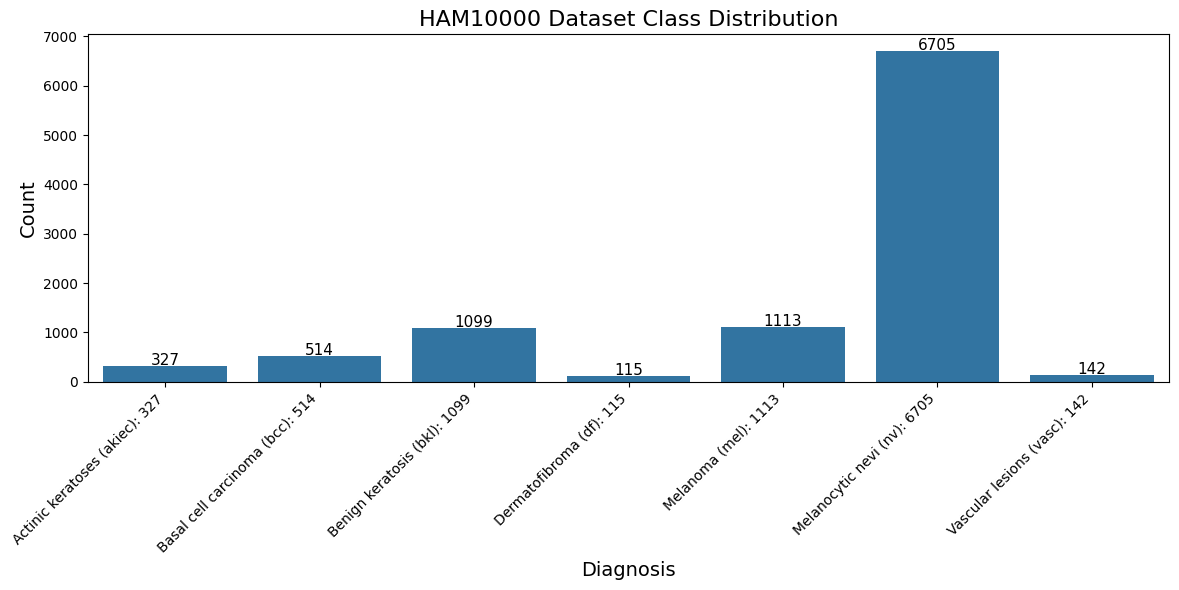

Duplicate lesion_ids: 2545 out of 10015


<ipython-input-3-68a55786744b>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-3-68a55786744b>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


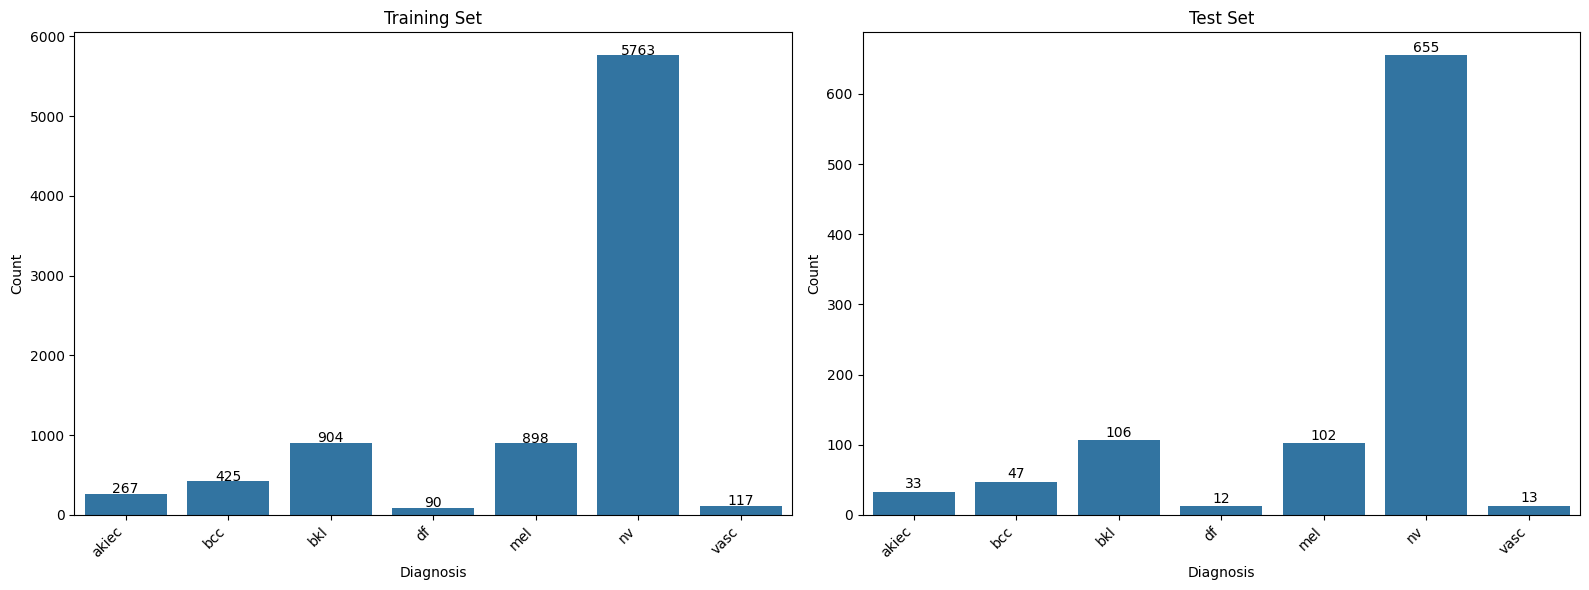

Training set: 8464 images
Test set: 968 images


In [3]:
def plot_data_distribution(df, title='Class Distribution'):
    plt.figure(figsize=(12, 6))
    counts = df['dx'].value_counts().sort_index()

    labels = [f"{lesion_type_dict[dx]} ({dx}): {count}" for dx, count in counts.items()]

    ax = sns.barplot(x=counts.index, y=counts.values)

    plt.title(title, fontsize=16)
    plt.xlabel('Diagnosis', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(range(len(counts)), labels, rotation=45, ha='right')

    for i, count in enumerate(counts.values):
        ax.text(i, count + 20, str(count), ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()

plot_data_distribution(df_data, 'HAM10000 Dataset Class Distribution')

def check_duplicates(df, col='lesion_id'):
    unique_list = df[col].unique().tolist()
    num_duplicates = len(df) - len(unique_list)
    return num_duplicates

num_duplicates = check_duplicates(df_data)
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_data)}')

df_train, df_test = train_test_split(df_data, test_size=0.1, stratify=df_data['label_numeric'], random_state=42)

df_test = df_test.reset_index()
df_train = df_train.reset_index()

df_test = df_test.drop_duplicates(subset='lesion_id', keep="first")

test_lesion_ids = set(df_test['lesion_id'].unique())
df_train = df_train[~df_train['lesion_id'].isin(test_lesion_ids)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (df, title) in enumerate([(df_train, 'Training Set'), (df_test, 'Test Set')]):
    counts = df['dx'].value_counts().sort_index()
    ax = axes[i]
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for j, count in enumerate(counts.values):
        ax.text(j, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

print(f"Training set: {len(df_train)} images")
print(f"Test set: {len(df_test)} images")

# Data Augmentation and Balance Function

In [4]:
def balance_data(train_data, oversample=True):
    if not oversample:
        print("Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False")
        return train_data

    balanced_train_data = []
    class_counts = train_data['label_numeric'].value_counts()

    nv_indices = train_data[train_data['dx'] == 'nv'].index
    nv_label = list(train_data[train_data['dx'] == 'nv']['label_numeric'].unique())[0]

    for class_label, count in class_counts.items():
        class_data = train_data[train_data['label_numeric'] == class_label]
        class_name = list(train_data[train_data['label_numeric'] == class_label]['dx'].unique())[0]

        if class_label == nv_label:
            balanced_train_data.append(class_data)
            print(f"Class '{class_name}' (original): {len(class_data)} samples")
        else:
            if count < 1500:
                n_samples_needed = 1500
                n_oversample = n_samples_needed - count

                full_copies = n_oversample // count
                remaining = n_oversample % count

                oversampled = pd.concat([class_data] * full_copies) if full_copies > 0 else pd.DataFrame()

                if remaining > 0:
                    additional = class_data.sample(n=remaining, replace=False, random_state=42)
                    oversampled = pd.concat([oversampled, additional])

                final_class_data = pd.concat([class_data, oversampled])
                balanced_train_data.append(final_class_data)
                print(f"Class '{class_name}' (oversampled): {len(final_class_data)} samples (original: {count})")
            else:
                balanced_train_data.append(class_data.sample(n=1500, random_state=42))
                print(f"Class '{class_name}' (downsampled): 1500 samples (original: {count})")

    balanced_data = pd.concat(balanced_train_data)
    return balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

common_aug_args = {
    "featurewise_center": False,
    "samplewise_center": False,
    "featurewise_std_normalization": False,
    "samplewise_std_normalization": False,
    "zca_whitening": False,
    "rotation_range": 10,
    "zoom_range": 0.1,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "horizontal_flip": False,
    "vertical_flip": False,
    "fill_mode": 'nearest'
}

if USE_AUGMENTATION_AND_OVERSAMPLING:
    tr_gen_rescale = ImageDataGenerator(rescale=1.0/255.0, **common_aug_args)
    tr_gen_no_rescale = ImageDataGenerator(**common_aug_args)
else:
    tr_gen_rescale = ImageDataGenerator(rescale=1.0/255.0)
    tr_gen_no_rescale = ImageDataGenerator()

ts_gen_rescale = ImageDataGenerator(rescale=1.0/255.0)
ts_gen_no_rescale = ImageDataGenerator()

# Models

In [5]:
def create_densenet_model(input_shape=(224, 224, 3), num_classes=7):
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_efficientnet_model(input_shape=(300, 300, 3), num_classes=7):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_resnet50_model(input_shape=(112, 150, 3), num_classes=7):
    base_model = ResNet50(
        include_top=False,
        input_shape=input_shape,
        pooling='avg',
        weights='imagenet'
    )

    model = Sequential([
        base_model,
        Dropout(0.5),
        Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.02))
    ])

    return model

def compile_model(model):
    opt = Adam(learning_rate=0.001)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

model_configs = {
    "ResNet50": {"img_size": (112, 150), "use_rescale": True, "model_func": create_resnet50_model},
    "EfficientNetB3": {"img_size": (300, 300), "use_rescale": False, "model_func": create_efficientnet_model},
    # "DenseNet201": {"img_size": (224, 224), "use_rescale": True, "model_func": create_densenet_model}

}

# Functions for Visualization

In [6]:
def plot_roc_curves(fpr, tpr, roc_auc, class_names, title='ROC Curves'):
    plt.figure(figsize=(12, 10))

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_training_history(history, model_name):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Training')
    if 'val_auc' in history.history:
        plt.plot(history.history['val_auc'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{model_name} - AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# K-Fold Cross-Validation Training


Starting 5-Fold CV for model: ResNet50

--- Fold 1 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 719)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 93)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 23,797,767 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 226s 391ms/step - accuracy: 0.5255 - auc: 0.8406 - loss: 3.9551 - val_accuracy: 0.6810 - val_auc: 0.8676 - val_loss: 1.7463 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 311ms/step - accuracy: 0.7091 - auc: 0.9420 - loss: 1.0659 - val_accuracy: 0.0585 - val_auc: 0.4955 - val_loss: 4.7237 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 311ms/step - accuracy: 0.7574 - auc: 0.9591 - loss: 0.8603 - val_accuracy: 0.7112 - val_auc: 0.9291 - val_loss: 1.2287 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 309ms/step - accuracy: 0.7844 - auc: 0.9662 - loss: 0.7724 - val_accuracy: 0.6994 - val_auc: 0.9332 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - accuracy: 0.7845 - auc: 0.9654 - loss: 0.7856 - val_accuracy: 0.7572 - val_auc: 0.9541 - val_loss: 0.9006 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 309ms/step - ac

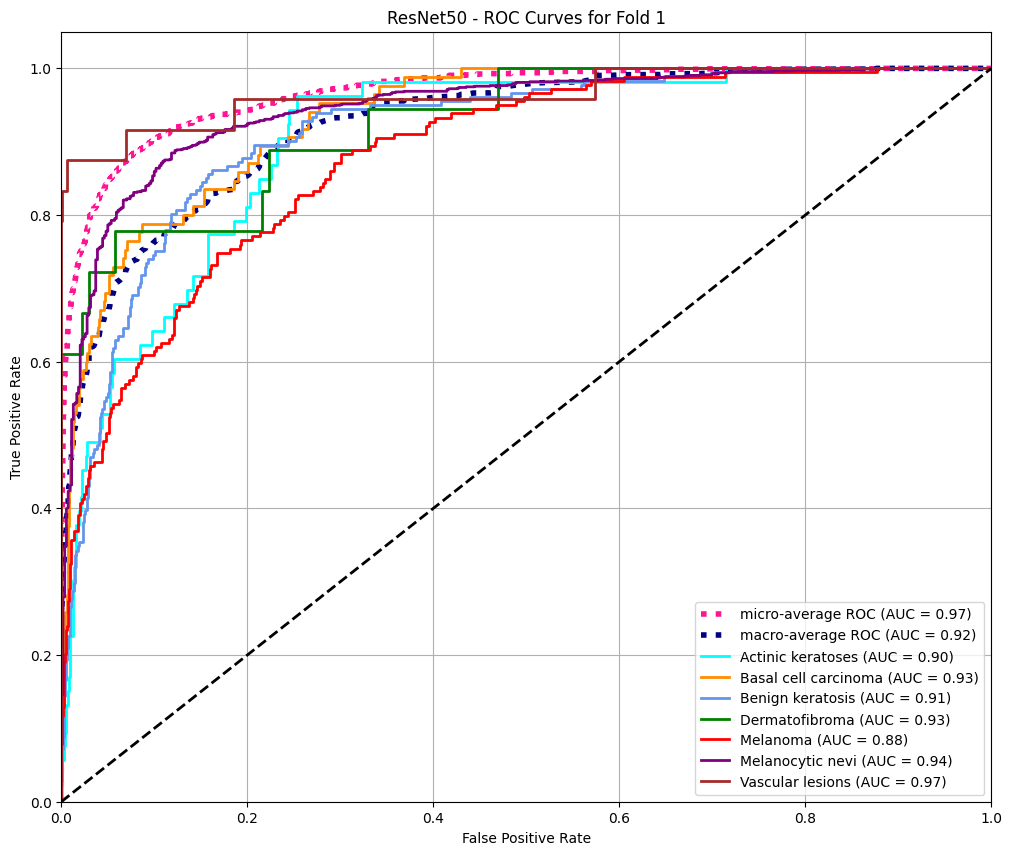


--- Fold 2 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 213s 371ms/step - accuracy: 0.5214 - auc: 0.8442 - loss: 3.9873 - val_accuracy: 0.6810 - val_auc: 0.8475 - val_loss: 1.6576 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - accuracy: 0.6892 - auc: 0.9350 - loss: 1.1429 - val_accuracy: 0.6804 - val_auc: 0.8361 - val_loss: 3.2953 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 309ms/step - accuracy: 0.7496 - auc: 0.9567 - loss: 0.8809 - val_accuracy: 0.6456 - val_auc: 0.8943 - val_loss: 1.4867 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7761 - auc: 0.9638 - loss: 0.7943
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 310ms/step - accuracy: 0.7761 - auc: 0.9638 - loss: 0.7943 - val_accuracy: 0.6137 - val_auc: 0.8941 - val_loss: 1.3238 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - accuracy: 0.8269 - auc:

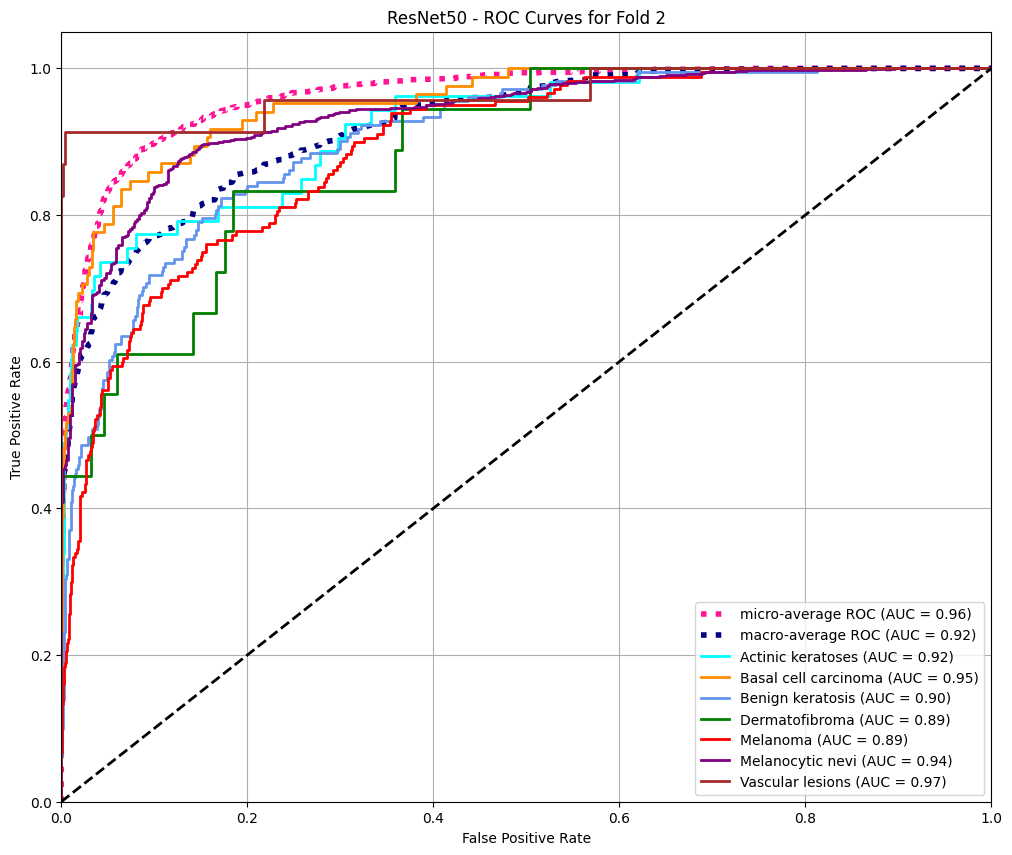


--- Fold 3 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 724)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 213)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 213s 370ms/step - accuracy: 0.5102 - auc: 0.8381 - loss: 3.9059 - val_accuracy: 0.0136 - val_auc: 0.4250 - val_loss: 7.8191 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 134s 313ms/step - accuracy: 0.7039 - auc: 0.9401 - loss: 1.1014 - val_accuracy: 0.1595 - val_auc: 0.5748 - val_loss: 3.5587 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - accuracy: 0.7443 - auc: 0.9558 - loss: 0.8903 - val_accuracy: 0.7106 - val_auc: 0.9408 - val_loss: 1.0082 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 310ms/step - accuracy: 0.7790 - auc: 0.9661 - loss: 0.7750 - val_accuracy: 0.7206 - val_auc: 0.9357 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 311ms/step - accuracy: 0.7890 - auc: 0.9686 - loss: 0.7424 - val_accuracy: 0.7047 - val_auc: 0.9270 - val_loss: 1.1868 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 311ms/step - ac

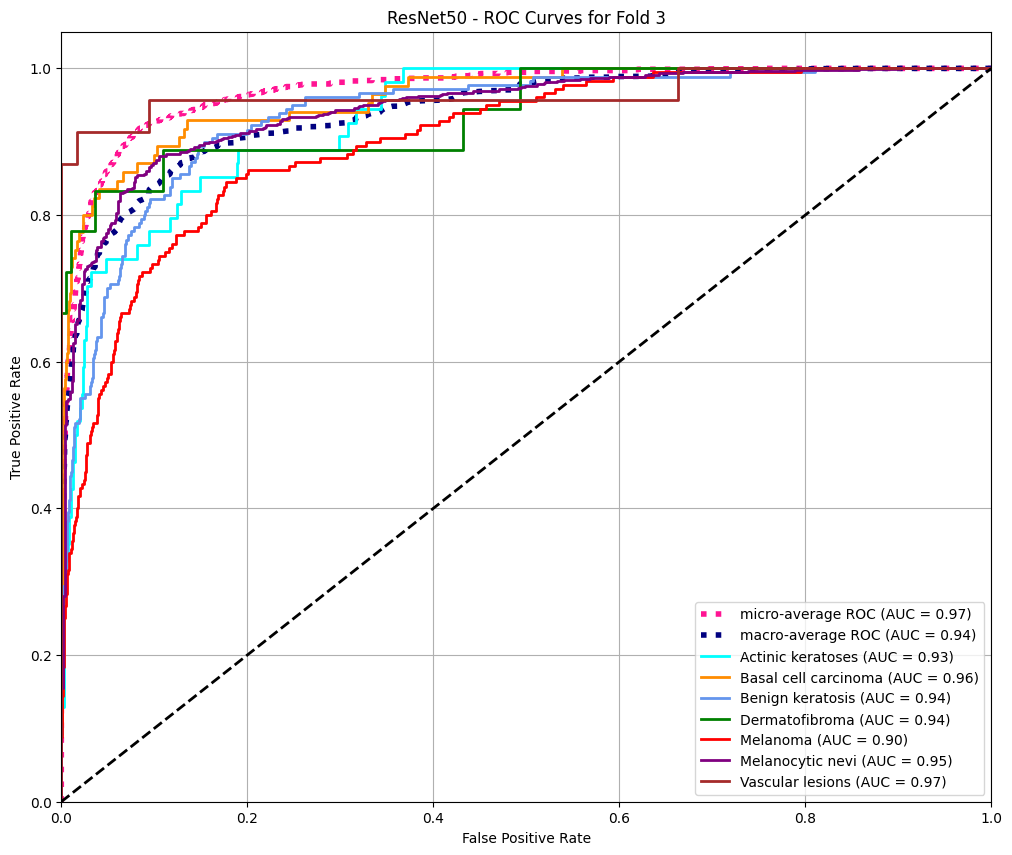


--- Fold 4 ---

Balancing training data...
Class 'nv' (original): 4611 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 213)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13611 samples
Found 13611 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 216s 379ms/step - accuracy: 0.5221 - auc: 0.8411 - loss: 3.9601 - val_accuracy: 0.6804 - val_auc: 0.8757 - val_loss: 1.4488 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - accuracy: 0.6996 - auc: 0.9391 - loss: 1.1135 - val_accuracy: 0.3131 - val_auc: 0.7181 - val_loss: 2.3214 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - accuracy: 0.7471 - auc: 0.9577 - loss: 0.8707 - val_accuracy: 0.7200 - val_auc: 0.9235 - val_loss: 1.4213 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - accuracy: 0.7830 - auc: 0.9679 - loss: 0.7581 - val_accuracy: 0.7431 - val_auc: 0.9537 - val_loss: 0.9496 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 134s 313ms/step - accuracy: 0.7906 - auc: 0.9701 - loss: 0.7309 - val_accuracy: 0.7112 - val_auc: 0.9230 - val_loss: 1.3838 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 311ms/step - ac

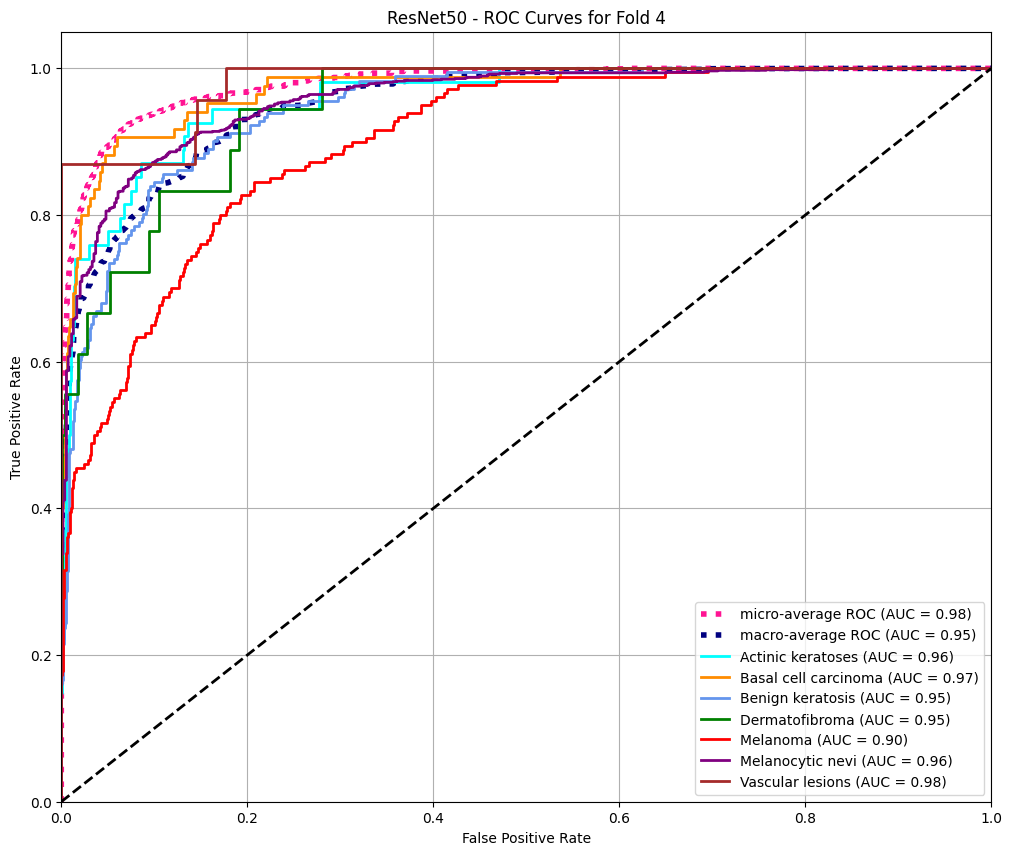


--- Fold 5 ---

Balancing training data...
Class 'nv' (original): 4611 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 719)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 93)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13611 samples
Found 13611 validated image filenames belonging to 7 classes.
Found 1692 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 216s 379ms/step - accuracy: 0.5059 - auc: 0.8335 - loss: 3.9605 - val_accuracy: 0.6809 - val_auc: 0.8799 - val_loss: 2.1170 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 311ms/step - accuracy: 0.7085 - auc: 0.9431 - loss: 1.0529 - val_accuracy: 0.5922 - val_auc: 0.8677 - val_loss: 1.4028 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 134s 314ms/step - accuracy: 0.7488 - auc: 0.9570 - loss: 0.8658 - val_accuracy: 0.6992 - val_auc: 0.9505 - val_loss: 0.9115 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 140s 311ms/step - accuracy: 0.7813 - auc: 0.9684 - loss: 0.7477 - val_accuracy: 0.6383 - val_auc: 0.9018 - val_loss: 1.4074 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 133s 312ms/step - accuracy: 0.7879 - auc: 0.9680 - loss: 0.7500 - val_accuracy: 0.7145 - val_auc: 0.9322 - val_loss: 1.2039 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 132s 309ms/step - ac

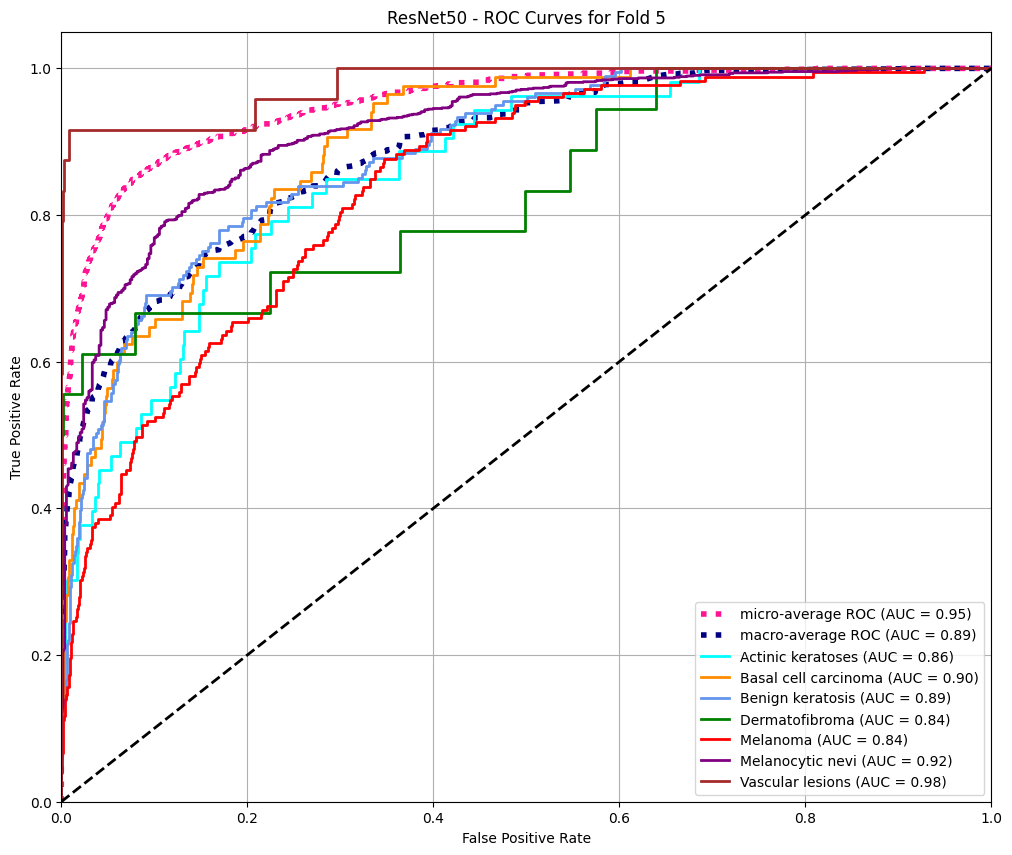


Model ResNet50 - CV Validation Accuracies for each fold: [0.8027170896530151, 0.7773183584213257, 0.808623731136322, 0.8363851308822632, 0.7618203163146973]
Model ResNet50 - Mean Validation Accuracy: 0.7974
Model ResNet50 - CV Validation AUC for each fold: [0.9444441795349121, 0.9515711069107056, 0.9589428305625916, 0.962992250919342, 0.9221305251121521]
Model ResNet50 - Mean Validation AUC: 0.9480


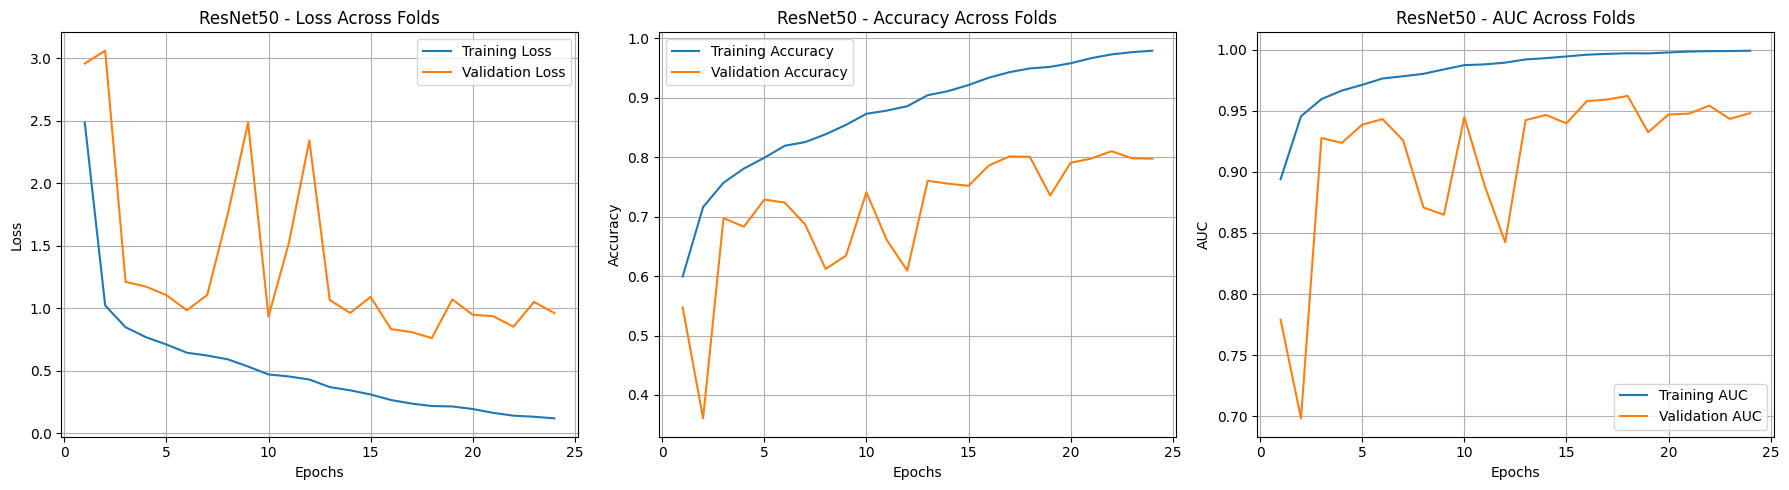


Starting 5-Fold CV for model: EfficientNetB3

--- Fold 1 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 719)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 93)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,639,606 (44.40 MB)

 Trainable params: 854,791 (3.26 MB)

 Non-trainable params: 10,784,815 (41.14 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 400s 844ms/step - accuracy: 0.3324 - auc: 0.6838 - loss: 2.5450 - val_accuracy: 0.6929 - val_auc: 0.9273 - val_loss: 0.9098 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 321s 753ms/step - accuracy: 0.4832 - auc: 0.8314 - loss: 1.4293 - val_accuracy: 0.7147 - val_auc: 0.9409 - val_loss: 0.8460 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 320s 750ms/step - accuracy: 0.5202 - auc: 0.8611 - loss: 1.2721 - val_accuracy: 0.7141 - val_auc: 0.9474 - val_loss: 0.8075 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 320s 752ms/step - accuracy: 0.5572 - auc: 0.8832 - loss: 1.1718 - val_accuracy: 0.7212 - val_auc: 0.9493 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 321s 754ms/step - accuracy: 0.5841 - auc: 0.8954 - loss: 1.1115 - val_accuracy: 0.7295 - val_auc: 0.9538 - val_loss: 0.7642 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 321s 755ms/step - ac

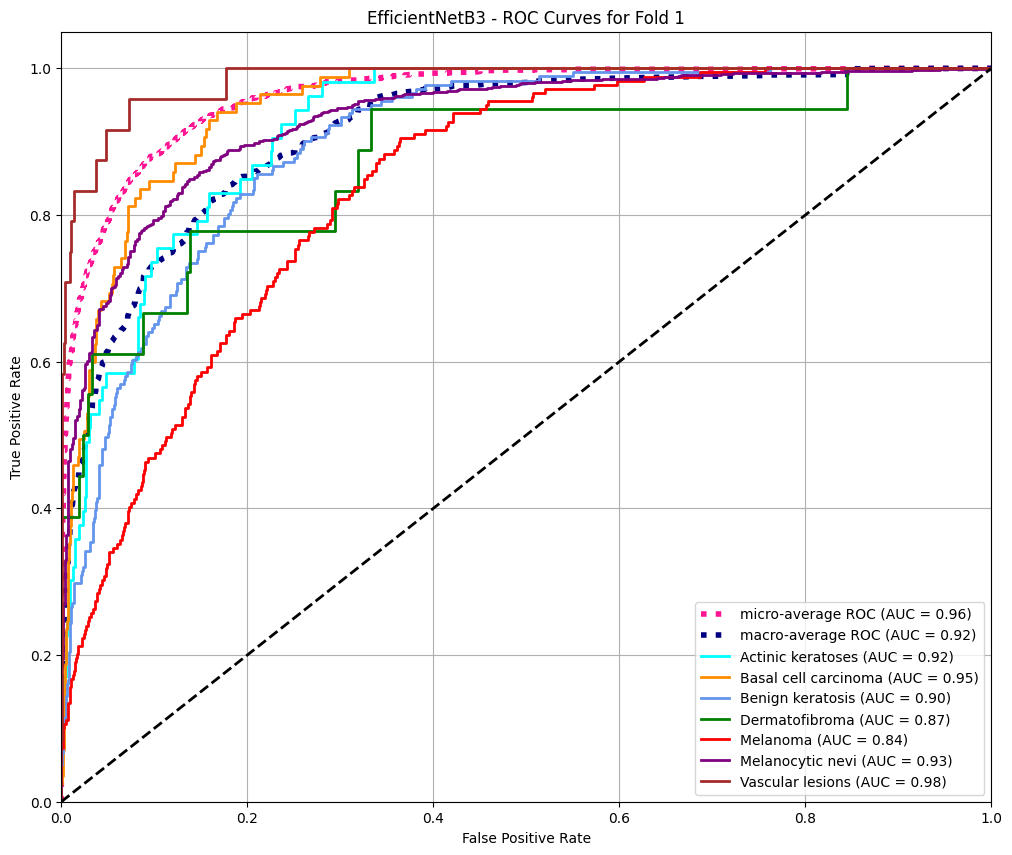


--- Fold 2 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 381s 813ms/step - accuracy: 0.3034 - auc: 0.6727 - loss: 2.5202 - val_accuracy: 0.6610 - val_auc: 0.9248 - val_loss: 0.9374 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 318s 745ms/step - accuracy: 0.4651 - auc: 0.8226 - loss: 1.4685 - val_accuracy: 0.6645 - val_auc: 0.9283 - val_loss: 0.9413 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 321s 754ms/step - accuracy: 0.5305 - auc: 0.8632 - loss: 1.2588 - val_accuracy: 0.7271 - val_auc: 0.9470 - val_loss: 0.8165 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 322s 756ms/step - accuracy: 0.5559 - auc: 0.8806 - loss: 1.1854 - val_accuracy: 0.7265 - val_auc: 0.9493 - val_loss: 0.7912 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 321s 753ms/step - accuracy: 0.5788 - auc: 0.8905 - loss: 1.1366 - val_accuracy: 0.6988 - val_auc: 0.9468 - val_loss: 0.8216 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accu

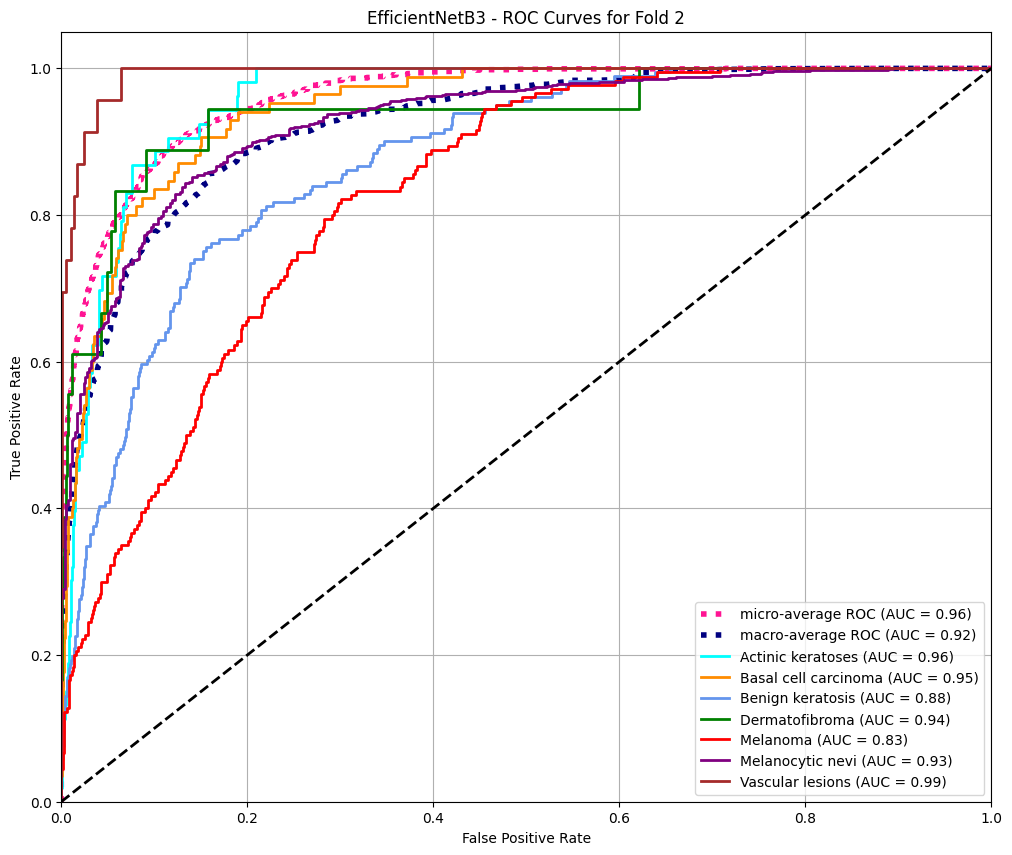


--- Fold 3 ---

Balancing training data...
Class 'nv' (original): 4610 samples
Class 'bkl' (oversampled): 1500 samples (original: 724)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 213)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13610 samples
Found 13610 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 386s 826ms/step - accuracy: 0.3067 - auc: 0.6778 - loss: 2.4560 - val_accuracy: 0.6804 - val_auc: 0.9370 - val_loss: 0.8636 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 318s 747ms/step - accuracy: 0.4861 - auc: 0.8306 - loss: 1.4267 - val_accuracy: 0.7029 - val_auc: 0.9421 - val_loss: 0.8574 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 319s 748ms/step - accuracy: 0.5334 - auc: 0.8679 - loss: 1.2415 - val_accuracy: 0.7129 - val_auc: 0.9478 - val_loss: 0.8083 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 322s 755ms/step - accuracy: 0.5545 - auc: 0.8813 - loss: 1.1825 - val_accuracy: 0.7230 - val_auc: 0.9529 - val_loss: 0.7785 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 322s 755ms/step - accuracy: 0.5762 - auc: 0.8936 - loss: 1.1208 - val_accuracy: 0.7271 - val_auc: 0.9535 - val_loss: 0.7791 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 322s 757ms/step - ac

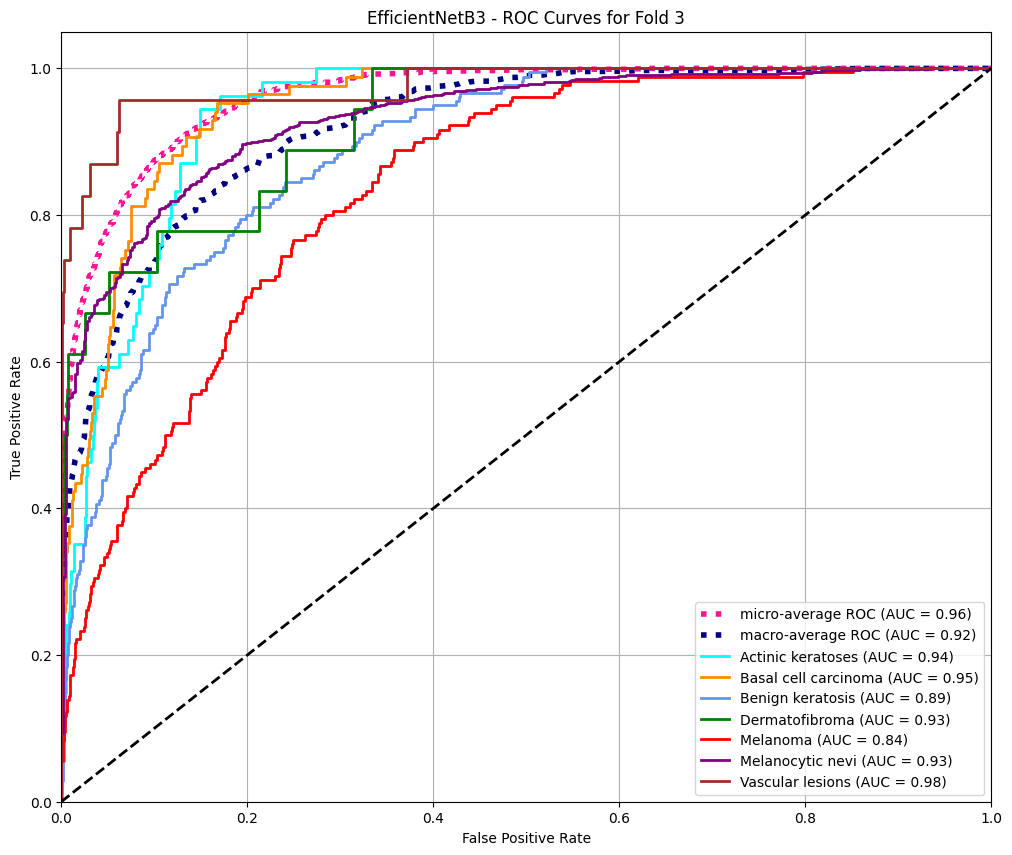


--- Fold 4 ---

Balancing training data...
Class 'nv' (original): 4611 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 718)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 213)
Class 'vasc' (oversampled): 1500 samples (original: 94)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13611 samples
Found 13611 validated image filenames belonging to 7 classes.
Found 1693 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 386s 825ms/step - accuracy: 0.3227 - auc: 0.6803 - loss: 2.5146 - val_accuracy: 0.6751 - val_auc: 0.9280 - val_loss: 0.9306 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 320s 752ms/step - accuracy: 0.4897 - auc: 0.8378 - loss: 1.4009 - val_accuracy: 0.7295 - val_auc: 0.9517 - val_loss: 0.7694 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 318s 747ms/step - accuracy: 0.5372 - auc: 0.8688 - loss: 1.2379 - val_accuracy: 0.7224 - val_auc: 0.9519 - val_loss: 0.7650 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 324s 759ms/step - accuracy: 0.5662 - auc: 0.8824 - loss: 1.1742 - val_accuracy: 0.7348 - val_auc: 0.9503 - val_loss: 0.7809 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 321s 754ms/step - accuracy: 0.5815 - auc: 0.8968 - loss: 1.1030 - val_accuracy: 0.7372 - val_auc: 0.9535 - val_loss: 0.7591 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 319s 749ms/step - ac

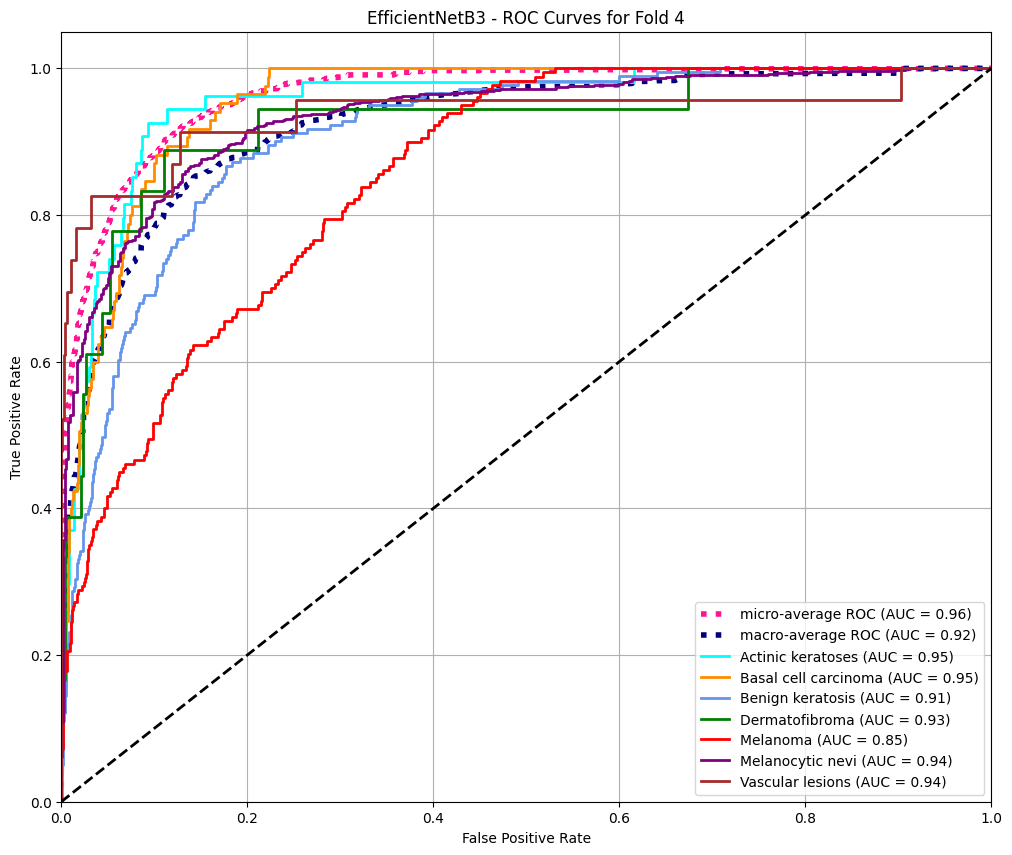


--- Fold 5 ---

Balancing training data...
Class 'nv' (original): 4611 samples
Class 'bkl' (oversampled): 1500 samples (original: 723)
Class 'mel' (oversampled): 1500 samples (original: 719)
Class 'bcc' (oversampled): 1500 samples (original: 340)
Class 'akiec' (oversampled): 1500 samples (original: 214)
Class 'vasc' (oversampled): 1500 samples (original: 93)
Class 'df' (oversampled): 1500 samples (original: 72)
Final balanced training set size: 13611 samples
Found 13611 validated image filenames belonging to 7 classes.
Found 1692 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 391s 839ms/step - accuracy: 0.3107 - auc: 0.6728 - loss: 2.5320 - val_accuracy: 0.6578 - val_auc: 0.9142 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 2/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 322s 755ms/step - accuracy: 0.4814 - auc: 0.8283 - loss: 1.4381 - val_accuracy: 0.7039 - val_auc: 0.9370 - val_loss: 0.8667 - learning_rate: 0.0010
Epoch 3/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 324s 759ms/step - accuracy: 0.5250 - auc: 0.8662 - loss: 1.2523 - val_accuracy: 0.7151 - val_auc: 0.9433 - val_loss: 0.8380 - learning_rate: 0.0010
Epoch 4/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 321s 754ms/step - accuracy: 0.5553 - auc: 0.8844 - loss: 1.1657 - val_accuracy: 0.7405 - val_auc: 0.9543 - val_loss: 0.7656 - learning_rate: 0.0010
Epoch 5/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 321s 755ms/step - accuracy: 0.5722 - auc: 0.8927 - loss: 1.1251 - val_accuracy: 0.7417 - val_auc: 0.9553 - val_loss: 0.7569 - learning_rate: 0.0010
Epoch 6/24
426/426 ━━━━━━━━━━━━━━━━━━━━ 322s 756ms/step - ac

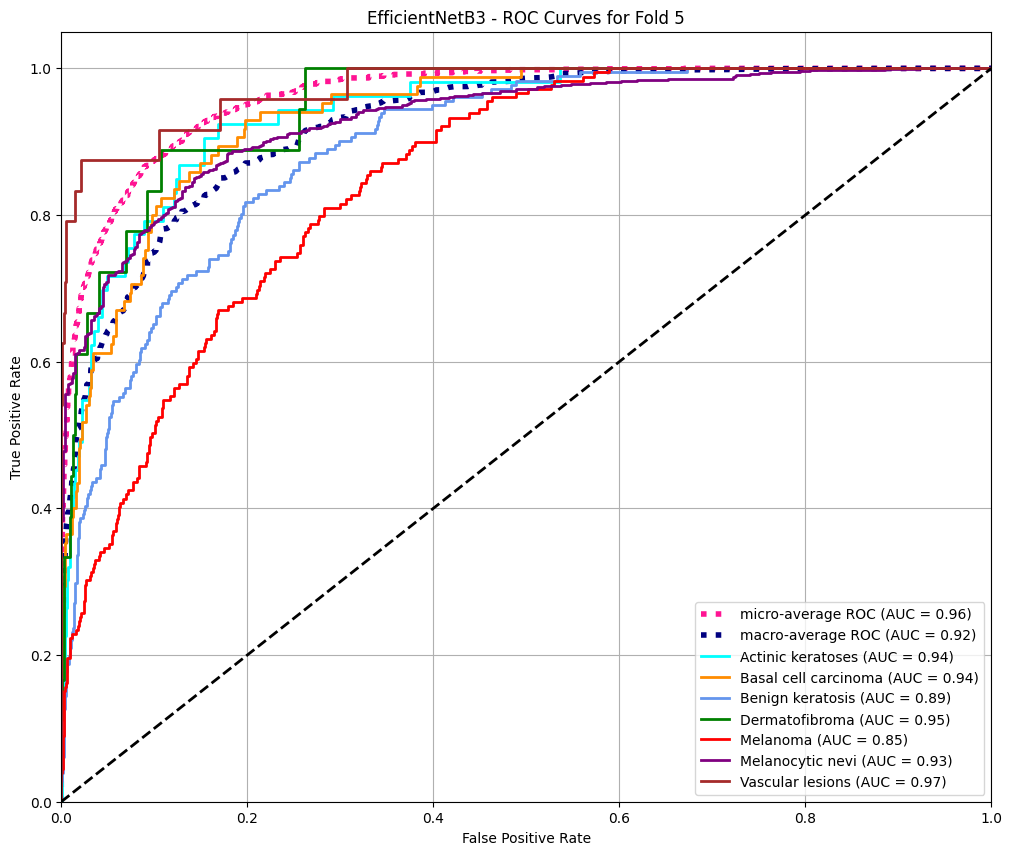


Model EfficientNetB3 - CV Validation Accuracies for each fold: [0.7566450238227844, 0.7359716296195984, 0.7525103092193604, 0.7578263282775879, 0.7576832175254822]
Model EfficientNetB3 - Mean Validation Accuracy: 0.7521
Model EfficientNetB3 - CV Validation AUC for each fold: [0.9634672403335571, 0.9598609209060669, 0.9622847437858582, 0.9644340872764587, 0.9623150825500488]
Model EfficientNetB3 - Mean Validation AUC: 0.9625


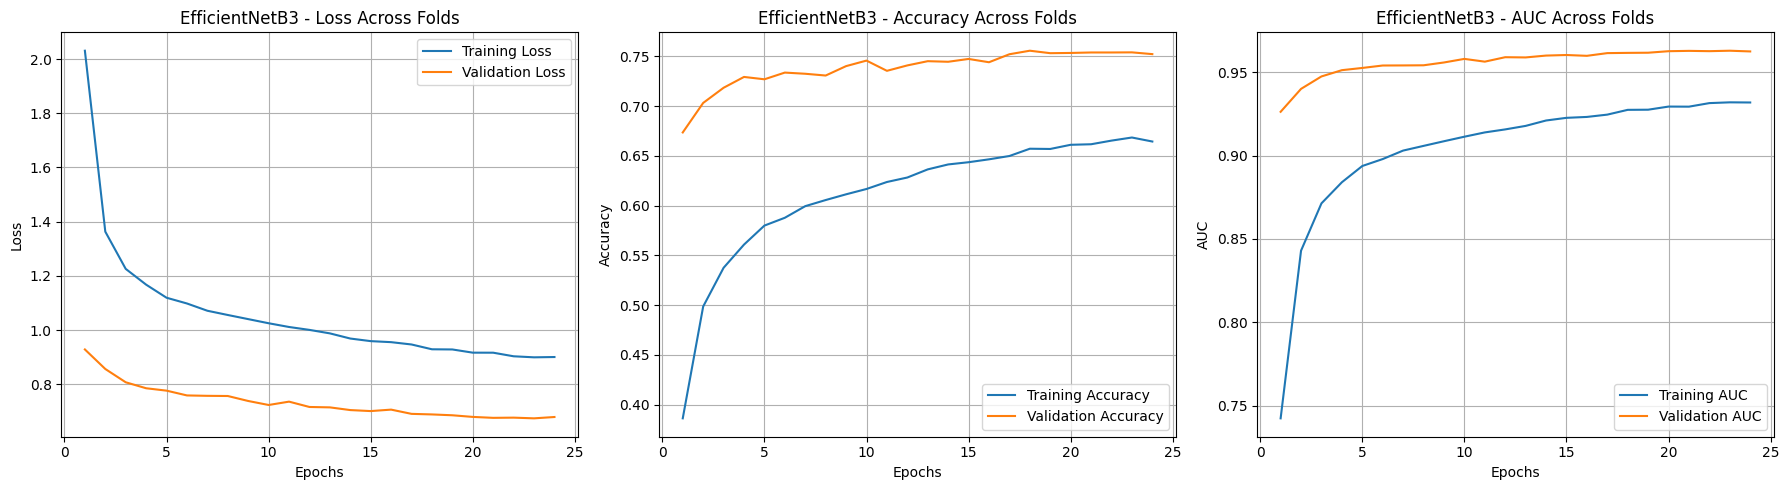

In [7]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
num_epochs = 24
batch_size = 32

for model_name, config in model_configs.items():
    print("\n================================================")
    print(f"Starting {num_folds}-Fold CV for model: {model_name}")
    print("================================================")

    img_size = config["img_size"]
    use_rescale = config["use_rescale"]
    model_func = config["model_func"]

    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []
    auc_per_fold = []
    val_loss_histories = []
    val_acc_histories = []
    val_auc_histories = []
    train_loss_histories = []
    train_acc_histories = []
    train_auc_histories = []

    roc_curves = {'fold': [], 'fpr': [], 'tpr': [], 'roc_auc': []}

    for train_index, val_index in skf.split(df_train, df_train['label_numeric']):
        print(f"\n--- Fold {fold_no} ---")
        train_data = df_train.iloc[train_index]
        val_data = df_train.iloc[val_index]

        print("\nBalancing training data...")
        balanced_train_data = balance_data(train_data, oversample=USE_AUGMENTATION_AND_OVERSAMPLING)
        print(f"Final balanced training set size: {len(balanced_train_data)} samples")

        if use_rescale:
            train_gen_fold = tr_gen_rescale.flow_from_dataframe(
                balanced_train_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=True,
                batch_size=batch_size
            )
            valid_gen_fold = ts_gen_rescale.flow_from_dataframe(
                val_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size
            )
        else:
            train_gen_fold = tr_gen_no_rescale.flow_from_dataframe(
                balanced_train_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=True,
                batch_size=batch_size
            )
            valid_gen_fold = ts_gen_no_rescale.flow_from_dataframe(
                val_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size
            )

        class_indices = train_gen_fold.class_indices
        class_names = list(class_indices.keys())

        model = model_func(input_shape=(img_size[0], img_size[1], 3), num_classes=len(class_indices))
        model = compile_model(model)

        if fold_no == 1:
            model.summary()

        history = model.fit(
            train_gen_fold,
            epochs=num_epochs,
            validation_data=valid_gen_fold,
            callbacks=[learning_rate_reduction],
            verbose=1
        )

        train_loss_histories.append(history.history['loss'])
        train_acc_histories.append(history.history['accuracy'])
        train_auc_histories.append(history.history['auc'])
        val_loss_histories.append(history.history['val_loss'])
        val_acc_histories.append(history.history['val_accuracy'])
        val_auc_histories.append(history.history['val_auc'])

        fold_val_loss, fold_val_acc, fold_val_auc = model.evaluate(valid_gen_fold)
        print(f"Fold {fold_no} - Validation Loss: {fold_val_loss:.4f}, Validation Accuracy: {fold_val_acc:.4f}, Validation AUC: {fold_val_auc:.4f}")

        loss_per_fold.append(fold_val_loss)
        acc_per_fold.append(fold_val_acc)
        auc_per_fold.append(fold_val_auc)

        y_pred = model.predict(valid_gen_fold)
        y_true = np.array(valid_gen_fold.classes)
        class_names = list(valid_gen_fold.class_indices.keys())

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(len(class_indices)):
            y_true_binary = np.array(y_true == i, dtype=int)
            fpr[i], tpr[i], _ = roc_curve(
                y_true_binary,
                y_pred[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(
            tf.keras.utils.to_categorical(y_true, num_classes=len(class_indices)).ravel(),
            y_pred.ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_indices))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(class_indices)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(class_indices)
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        roc_curves['fold'].append(fold_no)
        roc_curves['fpr'].append(fpr)
        roc_curves['tpr'].append(tpr)
        roc_curves['roc_auc'].append(roc_auc)

        lesion_names = [lesion_type_dict[key] for key in class_names]
        plot_roc_curves(fpr, tpr, roc_auc, lesion_names, f"{model_name} - ROC Curves for Fold {fold_no}")

        del model
        tf.keras.backend.clear_session()
        gc.collect()

        fold_no += 1

    print(f"\nModel {model_name} - CV Validation Accuracies for each fold: {acc_per_fold}")
    print(f"Model {model_name} - Mean Validation Accuracy: {np.mean(acc_per_fold):.4f}")
    print(f"Model {model_name} - CV Validation AUC for each fold: {auc_per_fold}")
    print(f"Model {model_name} - Mean Validation AUC: {np.mean(auc_per_fold):.4f}")

    avg_train_loss = np.mean(np.array(train_loss_histories), axis=0)
    avg_train_accuracy = np.mean(np.array(train_acc_histories), axis=0)
    avg_train_auc = np.mean(np.array(train_auc_histories), axis=0)
    avg_val_loss = np.mean(np.array(val_loss_histories), axis=0)
    avg_val_accuracy = np.mean(np.array(val_acc_histories), axis=0)
    avg_val_auc = np.mean(np.array(val_auc_histories), axis=0)
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, avg_train_loss, label='Training Loss')
    plt.plot(epochs_range, avg_val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Across Folds')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, avg_train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, avg_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy Across Folds')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, avg_train_auc, label='Training AUC')
    plt.plot(epochs_range, avg_val_auc, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{model_name} - AUC Across Folds')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Final Training and Evaluation


Final Training and Evaluation for model: ResNet50

Balancing full training data for final model...
Class 'nv' (original): 5763 samples
Class 'bkl' (oversampled): 1500 samples (original: 904)
Class 'mel' (oversampled): 1500 samples (original: 898)
Class 'bcc' (oversampled): 1500 samples (original: 425)
Class 'akiec' (oversampled): 1500 samples (original: 267)
Class 'vasc' (oversampled): 1500 samples (original: 117)
Class 'df' (oversampled): 1500 samples (original: 90)
Final balanced full training set size: 14763 samples
Found 14763 validated image filenames belonging to 7 classes.
Found 968 validated image filenames belonging to 7 classes.

--- Final training on full training data ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 206s 328ms/step - accuracy: 0.5345 - auc: 0.8516 - loss: 3.8441 - learning_rate: 0.0010
Epoch 2/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 134s 289ms/step - accuracy: 0.7189 - auc: 0.9459 - loss: 1.0144 - learning_rate: 0.0010
Epoch 3/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 134s 289ms/step - accuracy: 0.7559 - auc: 0.9597 - loss: 0.8373 - learning_rate: 0.0010
Epoch 4/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 134s 290ms/step - accuracy: 0.7679 - auc: 0.9623 - loss: 0.8062 - learning_rate: 0.0010
Epoch 5/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 135s 292ms/step - accuracy: 0.7872 - auc: 0.9677 - loss: 0.7520 - learning_rate: 0.0010
Epoch 6/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 133s 288ms/step - accuracy: 0.7982 - auc: 0.9710 - loss: 0.7109 - learning_rate: 0.0010
Epoch 7/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 133s 289ms/step - accuracy: 0.8082 - auc: 0.9746 - loss: 0.6647 - learning_rate: 0.0010
Epoch 8/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 133s 289ms/step - accuracy: 0.8258 - auc: 0.9771 - loss: 0.6293 

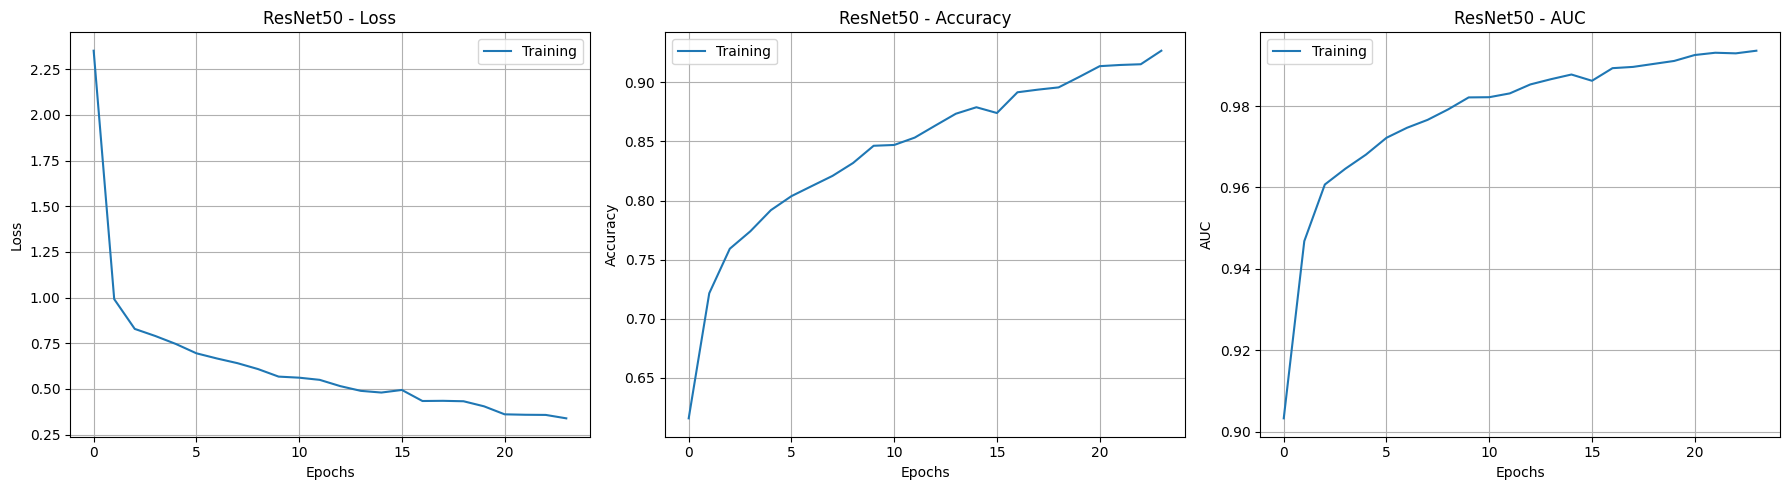


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 294ms/step - accuracy: 0.6888 - auc: 0.9243 - loss: 1.0904

Test Loss for ResNet50: 1.1351
Test Accuracy for ResNet50: 0.6870
Test AUC for ResNet50: 0.9197

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step


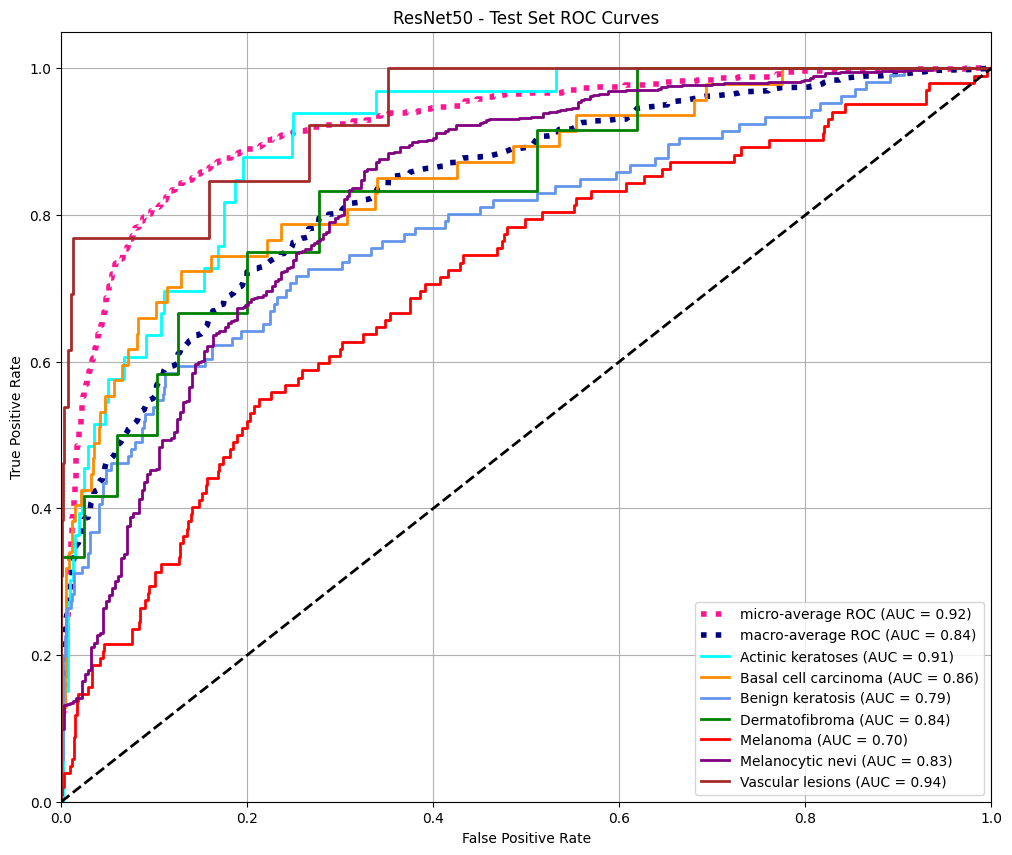


Generating confusion matrix...


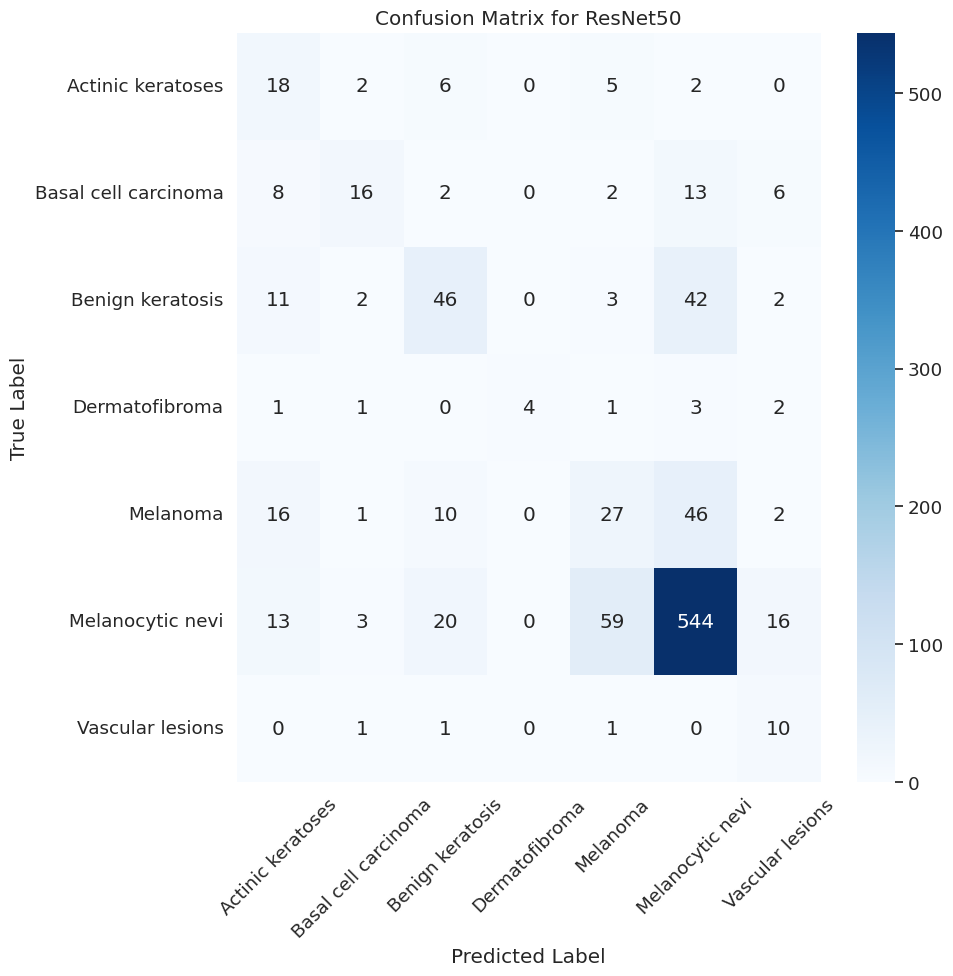


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.27      0.55      0.36        33
Basal cell carcinoma       0.62      0.34      0.44        47
    Benign keratosis       0.54      0.43      0.48       106
      Dermatofibroma       1.00      0.33      0.50        12
            Melanoma       0.28      0.26      0.27       102
    Melanocytic nevi       0.84      0.83      0.83       655
    Vascular lesions       0.26      0.77      0.39        13

            accuracy                           0.69       968
           macro avg       0.54      0.50      0.47       968
        weighted avg       0.71      0.69      0.69       968


Final Training and Evaluation for model: EfficientNetB3

Balancing full training data for final model...
Class 'nv' (original): 5763 samples
Class 'bkl' (oversampled): 1500 samples (original: 904)
Class 'mel' (oversampled): 1500 samples (original: 898)
Class 'bcc' (oversampled): 1500 sampl

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 379s 748ms/step - accuracy: 0.3384 - auc: 0.6989 - loss: 2.4346 - learning_rate: 0.0010
Epoch 2/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 335s 725ms/step - accuracy: 0.5043 - auc: 0.8413 - loss: 1.3782 - learning_rate: 0.0010
Epoch 3/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 336s 726ms/step - accuracy: 0.5556 - auc: 0.8749 - loss: 1.2048 - learning_rate: 0.0010
Epoch 4/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 331s 716ms/step - accuracy: 0.5783 - auc: 0.8896 - loss: 1.1393 - learning_rate: 0.0010
Epoch 5/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 332s 719ms/step - accuracy: 0.5821 - auc: 0.8953 - loss: 1.1102 - learning_rate: 0.0010
Epoch 6/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 331s 716ms/step - accuracy: 0.5962 - auc: 0.8984 - loss: 1.0933 - learning_rate: 0.0010
Epoch 7/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 337s 729ms/step - accuracy: 0.6036 - auc: 0.9041 - loss: 1.0643 - learning_rate: 0.0010
Epoch 8/24
462/462 ━━━━━━━━━━━━━━━━━━━━ 333s 721ms/step - accuracy: 0.6170 - auc: 0.9110 - loss: 1.0257 

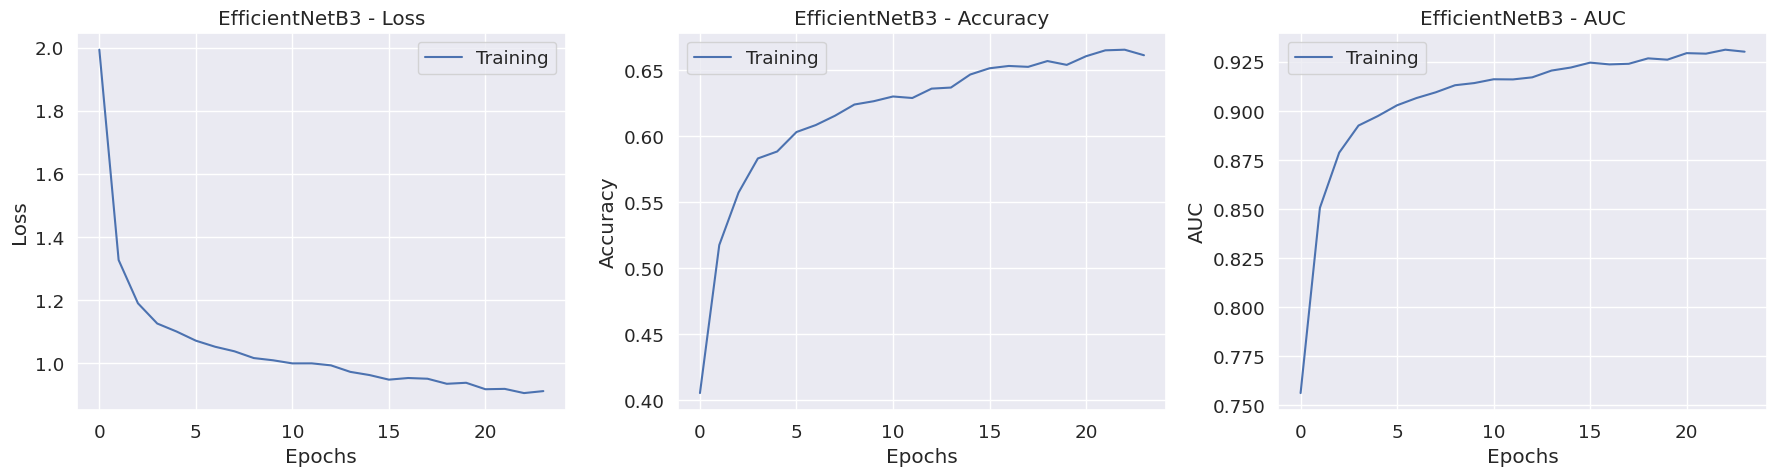


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 496ms/step - accuracy: 0.7440 - auc: 0.9573 - loss: 0.7203

Test Loss for EfficientNetB3: 0.7453
Test Accuracy for EfficientNetB3: 0.7190
Test AUC for EfficientNetB3: 0.9537

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 496ms/step


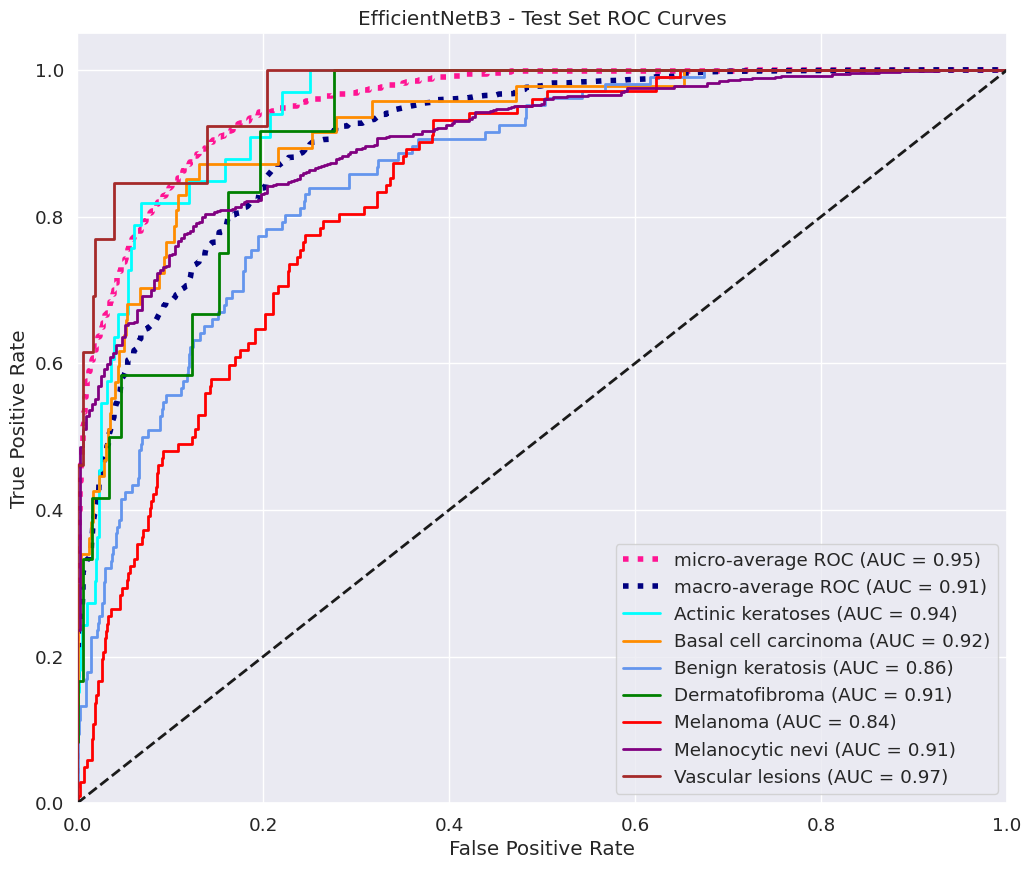


Generating confusion matrix...


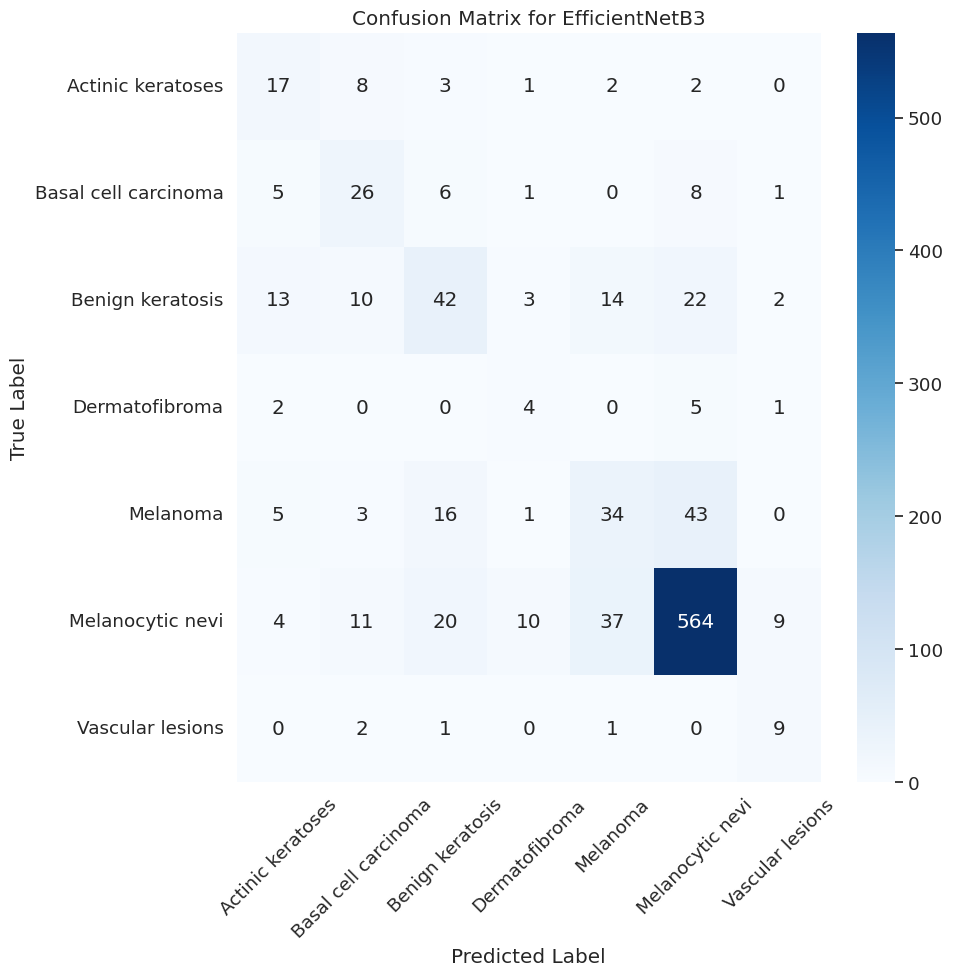


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.37      0.52      0.43        33
Basal cell carcinoma       0.43      0.55      0.49        47
    Benign keratosis       0.48      0.40      0.43       106
      Dermatofibroma       0.20      0.33      0.25        12
            Melanoma       0.39      0.33      0.36       102
    Melanocytic nevi       0.88      0.86      0.87       655
    Vascular lesions       0.41      0.69      0.51        13

            accuracy                           0.72       968
           macro avg       0.45      0.53      0.48       968
        weighted avg       0.73      0.72      0.72       968



In [8]:
for model_name, config in model_configs.items():
    print("\n================================================")
    print(f"Final Training and Evaluation for model: {model_name}")
    print("================================================")

    img_size = config["img_size"]
    use_rescale = config["use_rescale"]
    model_func = config["model_func"]

    print("\nBalancing full training data for final model...")
    balanced_df_train = balance_data(df_train, oversample=USE_AUGMENTATION_AND_OVERSAMPLING)
    print(f"Final balanced full training set size: {len(balanced_df_train)} samples")

    if use_rescale:
        train_gen_full = tr_gen_rescale.flow_from_dataframe(
            balanced_df_train,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )
        test_gen = ts_gen_rescale.flow_from_dataframe(
            df_test,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )
    else:
        train_gen_full = tr_gen_no_rescale.flow_from_dataframe(
            balanced_df_train,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )
        test_gen = ts_gen_no_rescale.flow_from_dataframe(
            df_test,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )

    num_classes = len(train_gen_full.class_indices)
    model = model_func(input_shape=(img_size[0], img_size[1], 3), num_classes=num_classes)
    model = compile_model(model)

    final_lr_reduction = ReduceLROnPlateau(
        monitor='accuracy',
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )

    print("\n--- Final training on full training data ---")
    history_full = model.fit(
        train_gen_full,
        epochs=num_epochs,
        callbacks=[final_lr_reduction],
        verbose=1
    )

    plot_training_history(history_full, model_name)

    print("\nEvaluating on test set...")
    score = model.evaluate(test_gen)
    loss, accuracy, auc_value = score
    print(f"\nTest Loss for {model_name}: {loss:.4f}")
    print(f"Test Accuracy for {model_name}: {accuracy:.4f}")
    print(f"Test AUC for {model_name}: {auc_value:.4f}")

    print("\nGenerating predictions for ROC curves...")
    y_pred = model.predict(test_gen)
    y_true = np.array(test_gen.classes)
    class_names = list(test_gen.class_indices.keys())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        y_true_binary = np.array(y_true == i, dtype=int)
        fpr[i], tpr[i], _ = roc_curve(
            y_true_binary,
            y_pred[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        tf.keras.utils.to_categorical(y_true, num_classes=num_classes).ravel(),
        y_pred.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lesion_names = [lesion_type_dict[key] for key in class_names]
    plot_roc_curves(fpr, tpr, roc_auc, lesion_names, f"{model_name} - Test Set ROC Curves")

    print("\nGenerating confusion matrix...")
    predictions = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, predictions)

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[lesion_type_dict[key] for key in class_names],
                yticklabels=[lesion_type_dict[key] for key in class_names])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(
        y_true,
        predictions,
        target_names=[lesion_type_dict[key] for key in class_names],
        zero_division=0
    ))

    del model
    tf.keras.backend.clear_session()
    gc.collect()